# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Day 0
21/08/2020

# Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.tsa import seasonal
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa._stl import STL

In [2]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [3]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

def year_diff(a, b):
    return (a.year - b.year)

In [4]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [5]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

# Import data
### Load csv

In [6]:
# Other datasets
# main_df = pd.read_csv('Data\competitive-data-science-predict-future-sales\sales_train.csv')
# main_df = pd.read_csv('Data\datasets_56102_107707_Electric_Production.csv')
# main_df = pd.read_csv('Data\datasets_56102_107707_daily-minimum-temperatures-in-me.csv')
# main_df = pd.read_csv('Data\datasets_56102_107707_sales-of-shampoo-over-a-three-ye.csv')
# main_df = pd.read_csv('Data/all_stocks_5yr.csv')

# Chosen one: beer production in Australia:
main_df = pd.read_csv('Data/datasets_56102_107707_monthly-beer-production-in-austr.csv')
# dataset can be found here https://www.kaggle.com/sergiomora823/monthly-beer-production?


display(main_df.head())
main_df.info()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [9]:
main_df.columns = ['month_datetime', 'monthly_beer_production']

date_column = 'month_datetime'
forecast_column = 'monthly_beer_production'

### First data checks

In [10]:
# Check available dates and intervals
main_df[date_column].values[:40]

array(['1956-01', '1956-02', '1956-03', '1956-04', '1956-05', '1956-06',
       '1956-07', '1956-08', '1956-09', '1956-10', '1956-11', '1956-12',
       '1957-01', '1957-02', '1957-03', '1957-04', '1957-05', '1957-06',
       '1957-07', '1957-08', '1957-09', '1957-10', '1957-11', '1957-12',
       '1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
       '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
       '1959-01', '1959-02', '1959-03', '1959-04'], dtype=object)

In [11]:
# Count nulls
main_df.isna().sum()

month_datetime             0
monthly_beer_production    0
dtype: int64

In [12]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column]:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,month_datetime,monthly_beer_production
1956-01-01,1956-01-01,93.2
1956-02-01,1956-02-01,96.0
1956-03-01,1956-03-01,95.2
1956-04-01,1956-04-01,77.1
1956-05-01,1956-05-01,70.9


,month_datetime,monthly_beer_production
1995-04-01,1995-04-01,127.0
1995-05-01,1995-05-01,151.0
1995-06-01,1995-06-01,130.0
1995-07-01,1995-07-01,119.0
1995-08-01,1995-08-01,153.0


In [13]:
# Frequency seems daily. Let´s double check
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('days elapsed: ' + str((main_df.index.max() - main_df.index.min()).days + 1))
# print('months elapsed: ' + str(month_diff(main_df.index.max(), main_df.index.min()) + 1))
# print('years elapsed: ' + str(year_diff(main_df.index.max(), main_df.index.min()) + 1))

dataframe rows: 476
days elapsed: 14458


In [14]:
missing = main_df.loc[main_df[forecast_column].isna()]
display(missing)

,month_datetime,monthly_beer_production


## Create log(forecast_column)

In [15]:
main_df['log('+forecast_column+')'] = np.log(main_df[forecast_column])
main_df.head()

,month_datetime,monthly_beer_production,log(monthly_beer_production)
1956-01-01,1956-01-01,93.2,4.534748
1956-02-01,1956-02-01,96.0,4.564348
1956-03-01,1956-03-01,95.2,4.555980
1956-04-01,1956-04-01,77.1,4.345103
1956-05-01,1956-05-01,70.9,4.261270


## Add month column

In [18]:
main_df['year'] = main_df.index.year
main_df['month'] = main_df.index.month

main_df.head()

,month_datetime,monthly_beer_production,log(monthly_beer_production),year,month
1956-01-01,1956-01-01,93.2,4.534748,1956,1
1956-02-01,1956-02-01,96.0,4.564348,1956,2
1956-03-01,1956-03-01,95.2,4.555980,1956,3
1956-04-01,1956-04-01,77.1,4.345103,1956,4
1956-05-01,1956-05-01,70.9,4.261270,1956,5


# 2. EDA

### 2.1 Check time series evolution

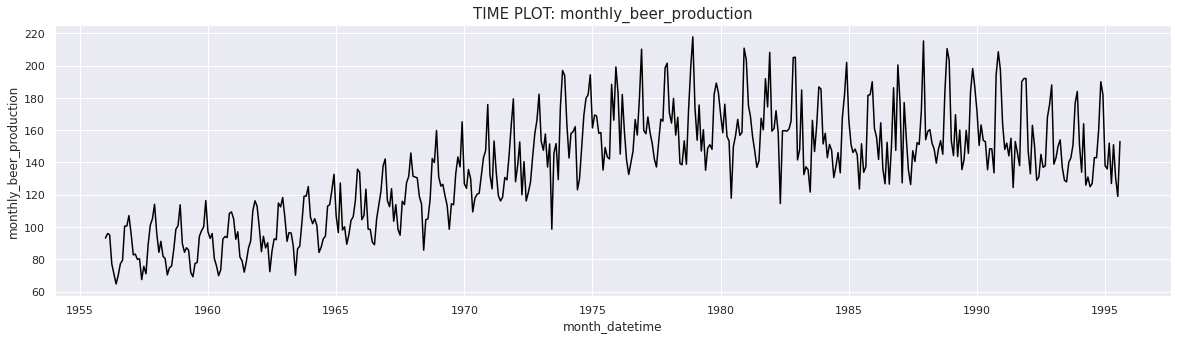

In [19]:
# Time plot: Original 
plt.title('TIME PLOT: '+forecast_column, size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df[forecast_column], color='black')
plt.show()

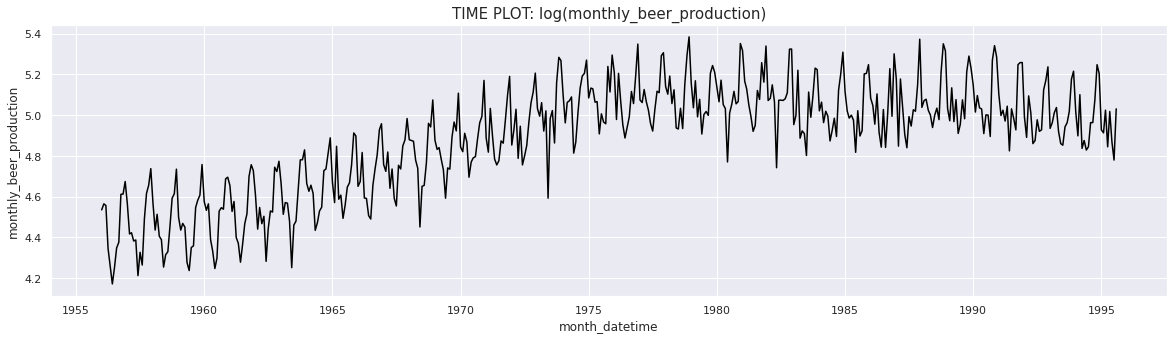

In [20]:
# Time plot: log transformation
plt.title('TIME PLOT: '+'log('+forecast_column+')', size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'], color='black')
plt.show()

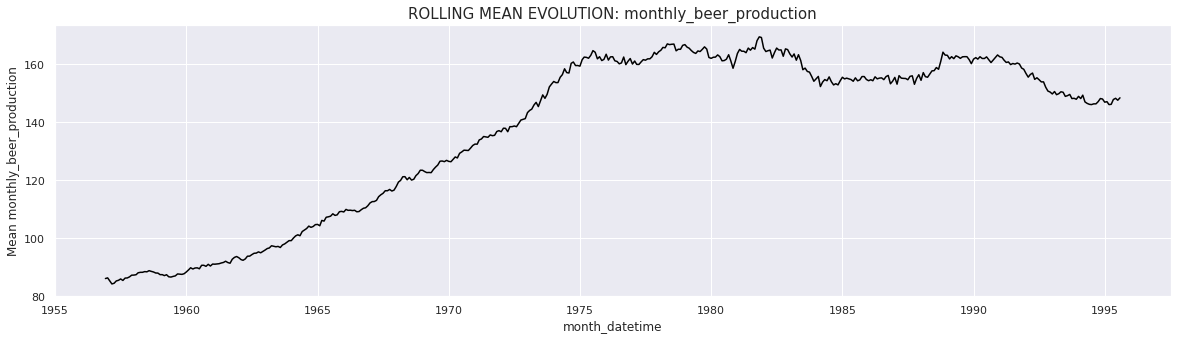

In [21]:
# Mean evolution: original
plt.title('ROLLING MEAN EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(12).mean(), color='black')
plt.show()

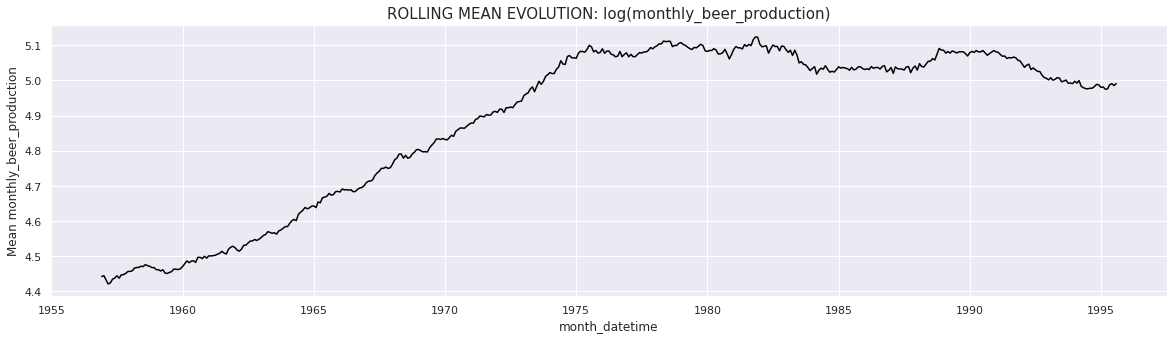

In [22]:
# Mean evolution: log transformation
plt.title('ROLLING MEAN EVOLUTION: '+'log('+forecast_column+')', size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'].rolling(12).mean(), color='black')
plt.show()

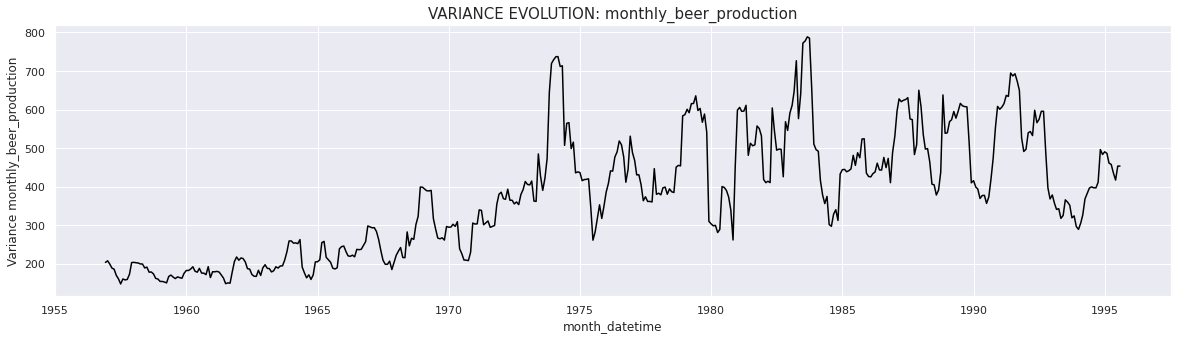

In [23]:
# Deviation evolution: original
plt.title('VARIANCE EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(12).var(), color='black')
plt.show()

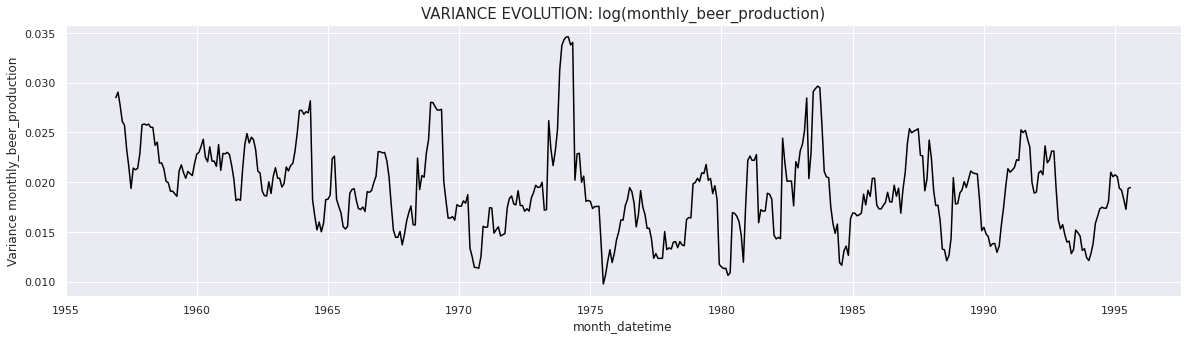

In [24]:
# Deviation evolution: log transformation
plt.title('VARIANCE EVOLUTION: '+'log('+forecast_column+')', size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'].rolling(12).var(), color='black')
plt.show()

### 2.2 Check seasonal plot

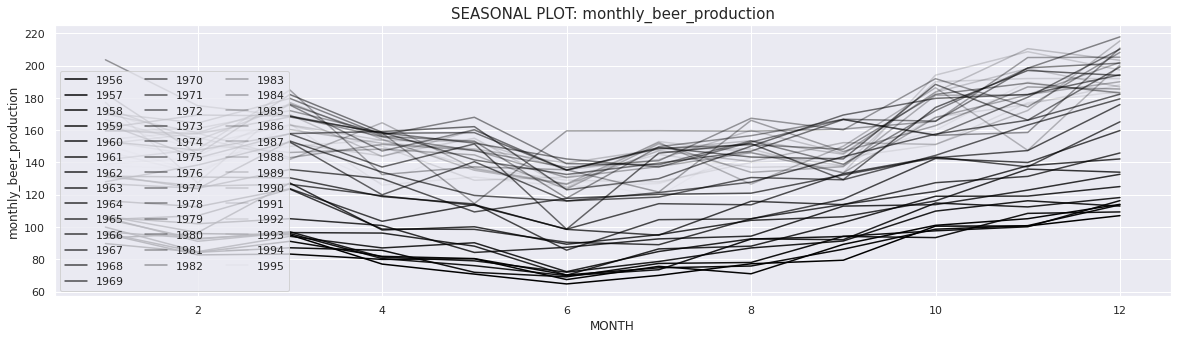

In [25]:
plt.title('SEASONAL PLOT: '+forecast_column, size=15)

years_list = main_df.index.year.unique()
for i, year in enumerate(years_list):
    df_i = main_df.loc[main_df.index.year==year]
    plt.plot(df_i.index.month, df_i[forecast_column], color='black', alpha=(1-i/len(years_list)), label=str(year))
plt.legend(loc="lower left", ncol=3)
plt.ylabel(forecast_column)
plt.xlabel('MONTH')
plt.show()

### 2.4 Autocorrelation

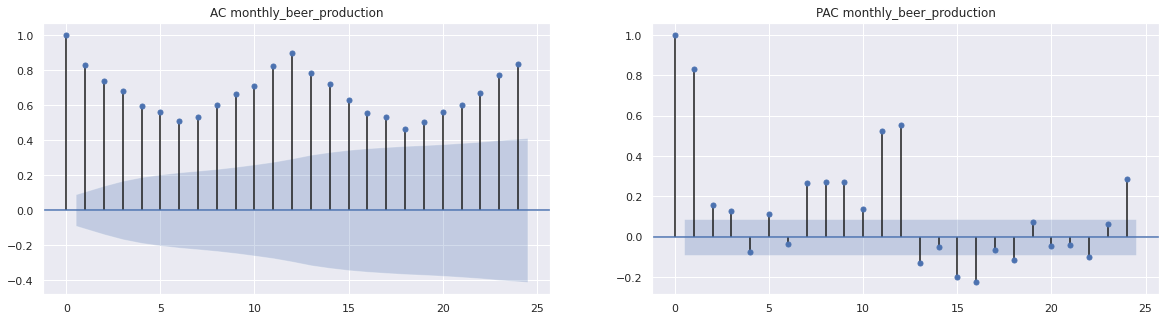

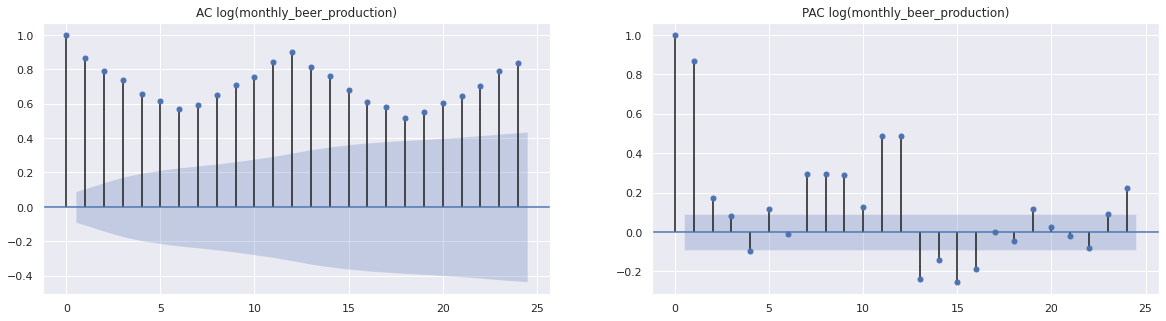

In [26]:
# Autocorrelation and partial autocorrelation
plot_AC_and_PAC(main_df[forecast_column], lags=24) # Original
plot_AC_and_PAC(main_df['log('+forecast_column+')'], lags=24) # Log transformation

### 2.5 STL Decomposition

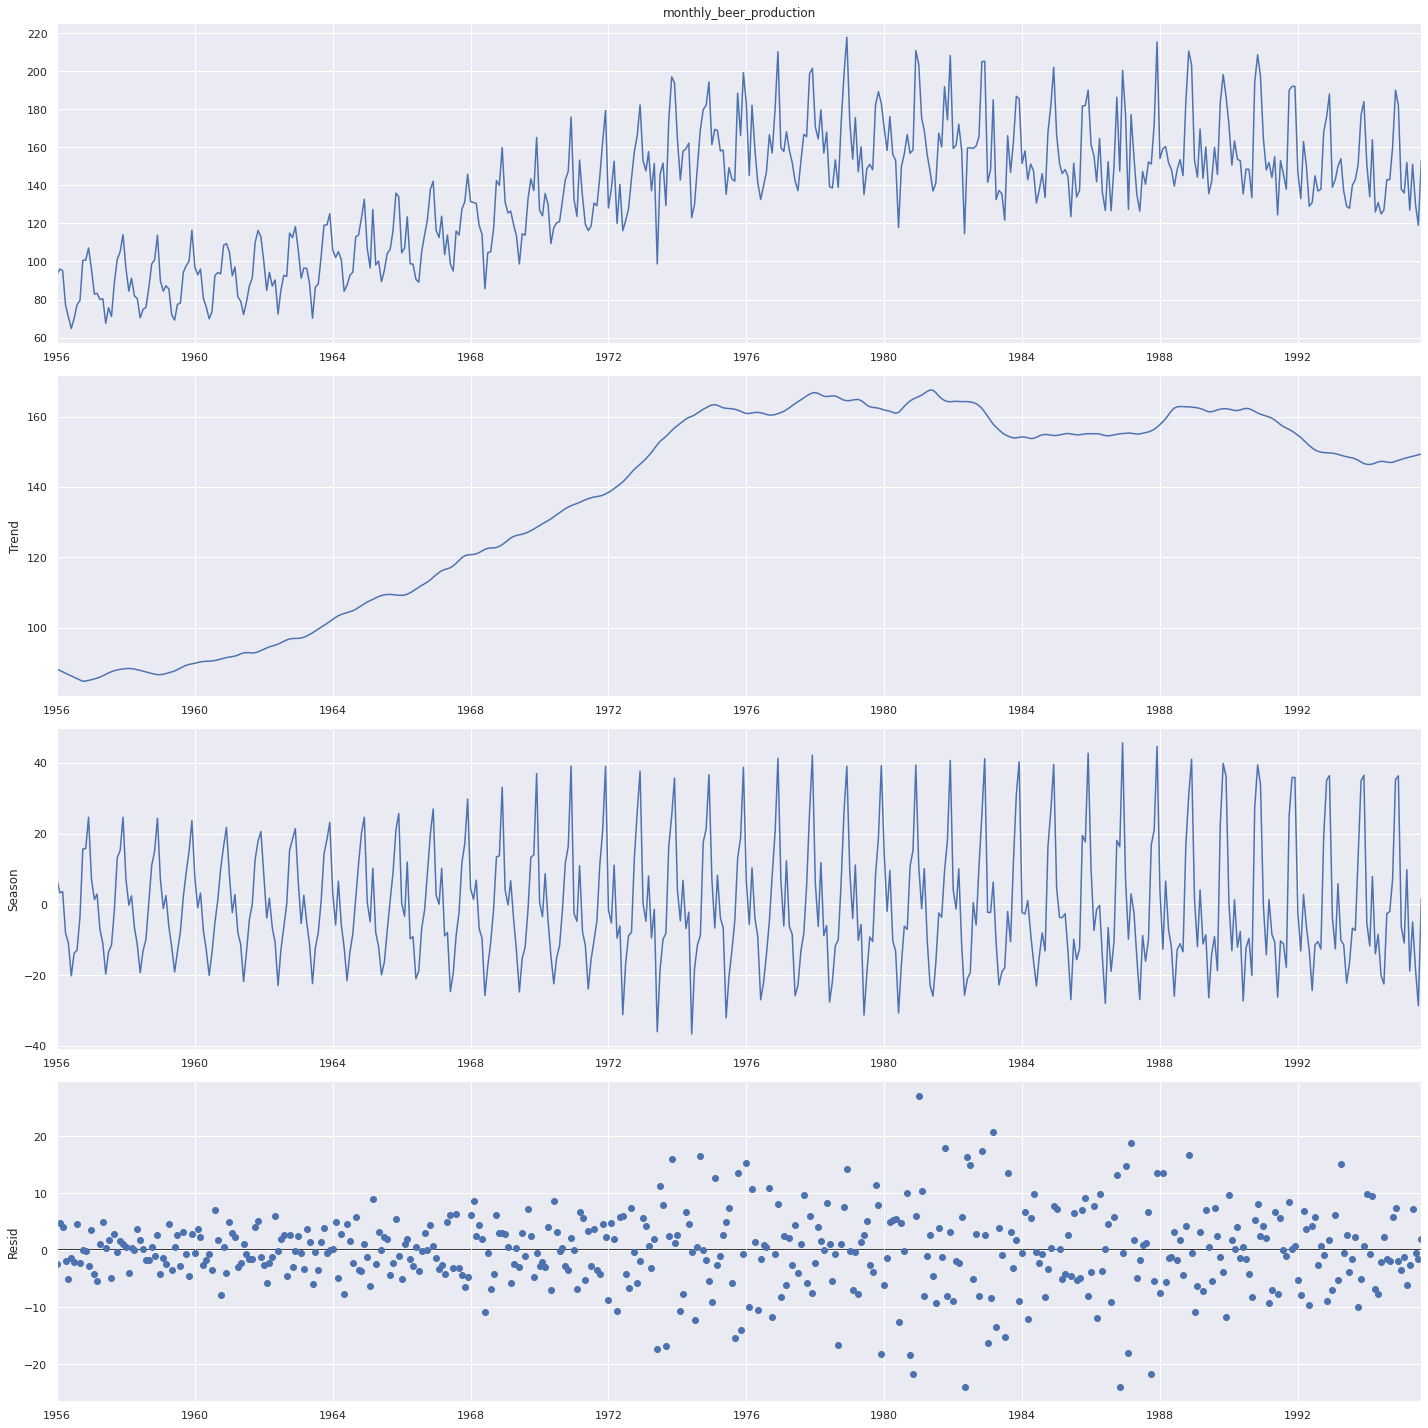

In [27]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html
plt.rcParams['figure.figsize'] = 20,20
res = STL(main_df[forecast_column], period=12).fit()
fig = res.plot()
plt.show()
plt.rcParams['figure.figsize'] = (20, 5)

In [28]:
# Strenth of components
# Reference: https://otexts.com/fpp2/seasonal-strength.html
Tt = getattr(res, 'trend') # smoothed trend component
St = getattr(res, 'seasonal') # seasonal component
Rt = getattr(res, 'resid') # remainder component

# Strenth of trend (0 - 1 | small - big trend)
Ft = max(0, 1-(np.var(Rt)/np.var(Tt+Rt)))
print("Strenth of trend: " +str(round(Ft,2)))

# Strenth of seasonality (0 - 1 | small - big seasonality)
Fs = max(0, 1-(np.var(Rt)/np.var(St+Rt)))
print("Strenth of seasonality: " +str(round(Fs,2)))

Strenth of trend: 0.95
Strenth of seasonality: 0.87


# Data Transformations

In [30]:
main_df.head()

,month_datetime,monthly_beer_production,log(monthly_beer_production),year,month
1956-01-01,1956-01-01,93.2,4.534748,1956,1
1956-02-01,1956-02-01,96.0,4.564348,1956,2
1956-03-01,1956-03-01,95.2,4.555980,1956,3
1956-04-01,1956-04-01,77.1,4.345103,1956,4
1956-05-01,1956-05-01,70.9,4.261270,1956,5


In [35]:
main_df[['monthly_beer_production', 'log(monthly_beer_production)', 'year', 'month']].to_csv('beer_production_Australia_JBC_day_0_v2.csv')

In [34]:
main_df.columns

Index(['month_datetime', 'monthly_beer_production',
       'log(monthly_beer_production)', 'year', 'month'],
      dtype='object')